In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [6]:
def cal_surprise(timeseries):
    l = timeseries.shape[0]
    surprise = 0
    for i in range(1, l):
        surprise += abs(timeseries[i] - timeseries[i-1])
    return surprise

def cal_emo(bookfile, scores, length):
    book = pd.DataFrame(bookfile)
    emo = np.zeros(length)
    for i in range(length):
        emo[i] = np.sum(scores*book[i])
    return emo

def generate_timeseries(bookfile, scores, length, minWindows):
    book = pd.DataFrame(bookfile)

    timeseries = np.zeros(length-minWindows+1)
    begtimeseries = np.zeros(int(minWindows/2))
    endtimeseries = np.zeros(int(minWindows/2))
    N = 0
    freq = np.zeros(book.shape[0])
    for j in range(int(minWindows/2)):
        freq += book[j]
    for j in range(int(minWindows/2), minWindows):
        N = np.sum(freq)
        happs = np.sum(scores*freq)
        begtimeseries[j-int(minWindows/2)] = happs/N
        freq += book[j]
    happs = np.sum(freq * scores)
    N = np.sum(freq)
    timeseries[0] = happs/N
    for j in range(1, length-minWindows+1):
        freq += book[j+minWindows-1]
        freq -= book[j-1]
        happs = np.sum(scores*freq)
        N = np.sum(freq)
        timeseries[j] = happs/N
    for j in range(length-minWindows+1, length):
        freq -= book[j-1]
        happs = np.sum(scores*freq)
        N = np.sum(freq)
        endtimeseries[j-length+int(minWindows/2)-1] = happs/N
    return timeseries, endtimeseries

In [7]:
length = 200
minWindows = 10
lower = 2668
upper = 9159
scorefile = pd.read_csv('./labMTscores-english.csv',
                        header=None, skiprows=range(lower, upper))
ds = pd.DataFrame(scorefile)
scores = np.array(ds).squeeze()
ds = pd.DataFrame(scorefile)
scores = np.array(ds).squeeze()

FileNotFoundError: [Errno 2] No such file or directory: './labMTscores-english.csv'

In [27]:
# # 找到拥有情感弧的那些小说
# with open('./real_detective.txt', 'a+') as f:
#     with open('./real_detective_downloads.txt', 'a+') as g:      
#         totlen = len(files)
#         for i in range(totlen):
#             if files[i][:-1] + str('.csv') in all_files:
#                 f.write(files[i][:-1] + '\n')
#                 g.write(str(downloads[i]) + '\n')

In [9]:
os.chdir('./data')
with open('./real_detective_downloads.txt', 'r') as fi:
    downloads = fi.readlines()
    downloads = list(map(int, downloads))
with open('./real_detective.txt', 'r') as fi:
    files = fi.readlines()

from tqdm import tqdm

surprises = []
for f in tqdm(files):
    bookfile = pd.read_csv('./detective/'+ f[:-1] + '.csv',header=None, skiprows=range(lower, upper))
    emo = cal_emo(bookfile, scores, length)
    surprise = cal_surprise(emo)
    surprises.append(surprise)

# surprises = []
# endsurprises = []
# for f in tqdm(files):
#     bookfile = pd.read_csv('./detective/'+ f[:-1] + '.csv',header=None, skiprows=range(lower, upper))
#     timeseries, endtimeseries = generate_timeseries(bookfile, scores, length, minWindows)
#     endsurprise = cal_surprise(endtimeseries)
#     # surprises.append(surprise)
#     endsurprises.append(endsurprise)

100%|██████████| 618/618 [08:57<00:00,  1.15it/s]


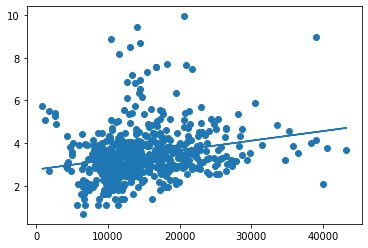

In [10]:
from scipy import stats
x = surprises
y = np.log(downloads)
slope, intercept, r, p, std_err = stats.linregress(x, y)

def line(x):
  return slope * x + intercept

model = list(map(line, x))

plt.scatter(x, y)
plt.plot(x, model)

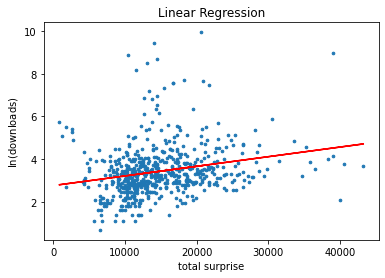

In [11]:
model = list(map(line, x))
plt.scatter(x, y, s=7)
plt.plot(x, model, color='r')
plt.xlabel('total surprise')
plt.ylabel('$\ln$(downloads)')
plt.title('Linear Regression')
plt.savefig('../results/Linear Regression total surprise noarc.png', dpi=200)

In [12]:
from sklearn.linear_model import RANSACRegressor
X = np.expand_dims(x, axis=1)
reg = RANSACRegressor(random_state=0).fit(X, y)

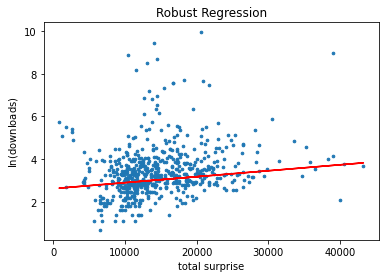

In [13]:
robust_model = reg.predict(X)
plt.scatter(x, y, s=7)
plt.plot(x, robust_model, color='r')
plt.xlabel('total surprise')
plt.ylabel('$\ln$(downloads)')
plt.title('Robust Regression')
plt.savefig('../results/Robust Regression total surprise noarc.png', dpi=200)

In [14]:
reg.score(X, y)

-0.062023066068504606

In [13]:
reg.estimator_.coef_

array([0.27252728])

In [15]:
slope, intercept, r, p, std_err

(4.498336693933037e-05,
 2.7692136310761377,
 0.23215915927745484,
 5.2303672723102266e-09,
 7.593548813802733e-06)

Text(0.5, 1.0, 'Robust Regression')

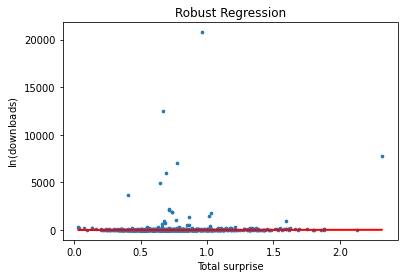

In [16]:
reg = RANSACRegressor(random_state=0).fit(X, np.exp(y))
plt.scatter(x, np.exp(y), s=7)
plt.plot(x, reg.predict(X), color='r')
plt.xlabel('Total surprise')
plt.ylabel('$\ln$(downloads)')
plt.title('Robust Regression')

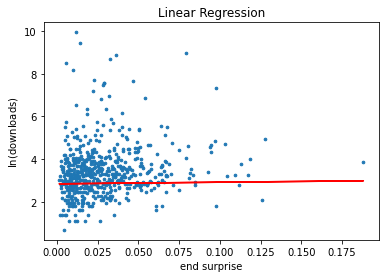

In [36]:
from scipy import stats
x2 = endsurprises
y2 = np.log(downloads)
slope2, intercept2, r, p2, std_err2 = stats.linregress(x2, y2)

def line(x):
  return slope * x + intercept

model2 = list(map(line, x2))
plt.xlabel('end surprise')
plt.ylabel('$\ln$(downloads)')
plt.title('Linear Regression')
plt.scatter(x2, y2, s=7)
plt.plot(x2, model2, color='r')
plt.savefig('../results/Linear Regression end surprise.png', dpi=200)

In [33]:
slope2, intercept2, r, p2, std_err2

(7.371418954161036,
 3.219644530363692,
 0.14082905591474762,
 0.0004457844772698878,
 2.087942568164221)

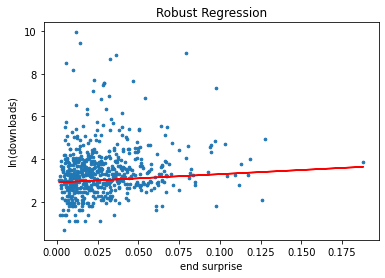

In [35]:
X2 = np.expand_dims(x2, axis=1)
reg = RANSACRegressor(random_state=0).fit(X2, y2)
robust_model = reg.predict(X2)
plt.scatter(x2, y2, s=7)
plt.plot(X2, robust_model, color='r')
plt.xlabel('end surprise')
plt.ylabel('$\ln$(downloads)')
plt.title('Robust Regression')
plt.savefig('../results/Robust Regression end surprise.png', dpi=200)